In [24]:
import numpy as np
import matplotlib.pyplot as plt
import random
import io
import math
from PIL import Image
from matplotlib.colors import LogNorm

In [2]:
def rand_positive_spanning_set(alpha, n):
#     create positive spanning sets (set of vectors whos positive span is R n)
    
    delta = round(1/math.sqrt(alpha))
#     create lower triangular matrix
    L = np.diag(delta*random.choices([-1,1], k=n))
    
#     create lower components of L
    for i in range(1,n-1):
        for j in range(1,i-1): 
            L[i,j] = np.random.randint(-delta+1 ,delta-1)
            
#     rows and columns of L are then randomly permuted to obtain a matrix D
    D = L[np.random.permutation(n),:]
    D = D[:, np.random.permutation(n)]
    
#     add one additional direction
    D = np.hstack((D ,np.array([-D.sum(axis=0)]).T))
    return [D[:,i] for i in range(n+1)]

In [5]:
class mesh_adaptive_direct_search:
    def __init__(self, f, X, epsilon):
        self.f = f
        self.X = X
        if not isinstance(self.X, np.ndarray):
            self.X = np.array([X])
        self.epsilon = epsilon
        
        self.y = f(X)
        self.alpha = 1 
        self.n = len(X)

        self.values = [self.y] # list of y values
        self.steps = [X] # list of x values
        
    def optimize(self):
        while self.alpha > self.epsilon:
            improved = False
            for (i,d) in enumerate(rand_positive_spanning_set(self.alpha, self.n)):
                x_next = self.X + self.alpha * d
                y_next = self.f(x_next)
                
#                 queries a new design point along the accepted descent direction
                if y_next < self.y:
                    self.X, self.y, improved = x_next, y_next, True
                    x_next = self.X + 3 * self.alpha * d
                    y_next = self.f(x_next)
                    if y_next < self.y:
                        self.X, self.y = x_next, y_next
                        self.values.append(y_next)
                        self.steps.append(x_next)
                    break
                self.values.append(y_next)
                self.steps.append(x_next)
                
#            update step size                
            if  improved == True:
                self.alpha = min(4* self.alpha, 1) 
            else: self.alpha = self.alpha/4
        self.steps.append(self.X)
        return self.X

In [50]:
def Booth(X):
    x, y = X
    return (x+2*y-7)**2 + (2*x+y-5)**2

f = Booth
X = np.array([-5, -5])
startingX = X

global_minima = np.array([1, 3])

In [51]:
mads = mesh_adaptive_direct_search(f=f, X=X, epsilon = 0.01)

mads.optimize()

array([1., 3.])

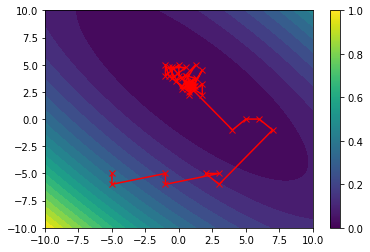

In [52]:
Xs = np.linspace(-10, 10, 1000)
Ys = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(Xs, Ys)

Z = Booth((X, Y))

# Plot countour
plt.contourf(X, Y, Z, levels=np.linspace(Z.min(), Z.max(), 20))
plt.scatter(global_minima[0], global_minima[1], c='w')
plt.colorbar()

# Plot steps taken
steps = np.array(mads.steps)
plt.plot(steps[:,0], steps[:,1], marker='x', c='red')
plt.show()

In [54]:
# Create GIF
steps = np.array(mads.steps)
frames = []
for i in range(steps.shape[0]):
    # Plot
    plt.contourf(X, Y, Z)
    plt.scatter(global_minima[0], global_minima[1], c='w')
    plt.plot(steps[:i+1, 0], steps[:i+1, 1], marker='x', color='r');
    # Save GIF frame to buffer
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png')
    plt.close()
    buffer.seek(0)
    
    # Load and store frame using PIL
    frame = Image.open(buffer)
    frames.append(frame)
# Save frame
frames[0].save(fp='mesh_adaptive_direct_search.gif', format='GIF',
               append_images=frames, save_all=True, duration=100, loop=0)

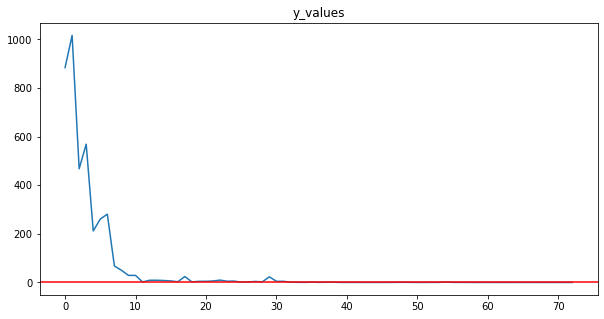

In [55]:
plt.figure(figsize=(10,5))
plt.plot(mads.values)
plt.axhline(y=Booth(global_minima), color='r', linestyle='-')
plt.title('y_values')
plt.show()